In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import importlib

import compare_rates
importlib.reload(compare_rates)

<module 'compare_rates' from '/Users/kelley/Projects/PhasingFamilies/parameter_estimation/compare_rates.py'>

In [17]:
chroms = [str(i) for i in range(1, 23)]

gens = ['0/0', '0/1', '1/1']
obss = ['0/0', '0/1', '1/1', './.']

# Population distributions

In [5]:
ihart_samples = compare_rates.pull_samples('../split_gen_ihart', chroms)
ihart32_samples = compare_rates.pull_samples('../split_gen_ihart3.2', chroms)

spark_exome_samples = compare_rates.pull_samples('../split_gen_spark_exome', chroms)
spark_samples = compare_rates.pull_samples('../split_gen_spark', chroms)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


In [18]:
ihart_error_rates = compare_rates.pull_error_rates(ihart_samples, 'params/ihart_params.json', gens, obss)
ihart_LCR_error_rates = compare_rates.pull_error_rates(ihart_samples, 'params/ihart_LCR_params.json', gens, obss)
ihart_HCR_error_rates = compare_rates.pull_error_rates(ihart_samples, 'params/ihart_HCR_params.json', gens, obss)
ihart_EX_error_rates = compare_rates.pull_error_rates(ihart_samples, 'params/ihart_EX_params.json', gens, obss)
ihart32_error_rates = compare_rates.pull_error_rates(ihart32_samples, 'params/ihart3.2_params.json', gens, obss)

spark_exome_EX_error_rates = compare_rates.pull_error_rates(spark_exome_samples, 'params/spark_exome_EX_params.json', gens, obss)

spark_error_rates = compare_rates.pull_error_rates(spark_samples, 'params/spark_params.json', gens, obss)


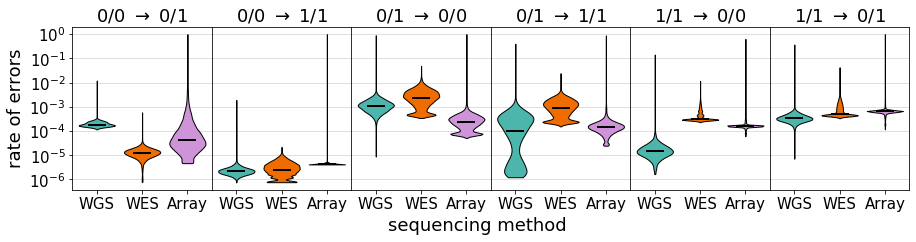

In [11]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#4db6ac', '#ef6c00', '#ce93d8', '#695d46', '#009668', '#b3a77d', '#cedd38']

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                      #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('sequencing method', y=0, fontsize=18)

for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    error_rates1 = -ihart_error_rates[:, g_index, o_index]
    error_rates1 = error_rates1[ihart_samples.is_child & ~np.isnan(error_rates1)]
    
    error_rates2 = -spark_exome_EX_error_rates[:, g_index, o_index]
    error_rates2 = error_rates2[spark_exome_samples.is_child & ~np.isnan(error_rates2)]
    
    error_rates3 = -spark_error_rates[:, g_index, o_index]
    error_rates3 = error_rates3[spark_samples.is_child & ~np.isnan(error_rates3)]
         
    parts = subs[i].violinplot([error_rates1, error_rates2, error_rates3],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticklabels(['', 'WGS', 'WES', 'Array'], {'fontsize': 15})
    subs[i].grid(True, axis='y', alpha=0.5)
    subs[i].set_axisbelow(True)
fig.subplots_adjust(wspace=0.0)


#plt.tight_layout()
#plt.savefig('../plots/sequencing_method.png')
plt.show()

In [12]:
def remove_nans(x):
    return x[~np.isnan(x)]

In [13]:
def plot_precision_recall(filename, prs, indices, labels, colors, ylim=[0, 5], dotted=False, rotate_xlabels=False):
    fig, subs = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
    fig.suptitle('Heterozygous (0/1) Sites                           Homozygous Alternate (1/1) Sites', 
                 fontsize=18, x=0.215, horizontalalignment='left')

    for i, attr in enumerate(['precision1', 'recall1', 'precision2', 'recall2']):

        parts = subs[i].violinplot([-np.log10(1-remove_nans(getattr(pr, attr)[ind])) for (pr, ind) in zip(prs, indices)], 
                                   showmedians=True, showextrema=False, widths=0.8)
        
        if dotted:
            subs[i].plot(np.arange(1, 1+len(prs)), 
                         [np.median(-np.log10(1-remove_nans(getattr(prs[0], attr)[indices[0]])))]*len(prs), 
                         color='black', linestyle='--')


        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_alpha(1)
        parts['cmedians'].set_edgecolor('black')
        parts['cmedians'].set_linewidth(2)

        if i == 0:
            subs[i].set_yticks(np.arange(1, 5))
            subs[i].set_yticklabels(['0.' + '9'*int(f) % f for f in subs[i].get_yticks()], {'fontsize': 15})
        else:
            subs[i].tick_params('y', length=0)
        subs[i].set_title(['Precision', 'Recall', 'Precision', 'Recall'][i], {'fontsize': 15})
        subs[i].set_xticks(np.arange(1, 1+len(prs)))
        subs[i].set_xticklabels(labels, {'fontsize': 15})
        subs[i].grid(True, axis='y', alpha=0.5)
        subs[i].set_axisbelow(True)
        subs[i].set_ylim(ylim)
        if rotate_xlabels:
            for tick in subs[i].get_xticklabels():
                tick.set_rotation(90)

    fig.subplots_adjust(wspace=0.0, top=0.8)
    #plt.show()
    plt.savefig(filename)

In [14]:
ihart_is_ok_sample = set()
with open('../data/170925.iHART.db.csv', 'r') as f:
    for line in f:
        pieces = line.strip().split(',')
        if pieces[0] == 'Passed_QC_analysis_ready':
            ihart_is_ok_sample.add(pieces[2])

In [24]:
ihart_precision_recall = compare_rates.pull_precision_recall(ihart_samples, 'params/ihart_params.json')
ihart_LCR_precision_recall = compare_rates.pull_precision_recall(ihart_samples, 'params/ihart_LCR_params.json')
ihart_HCR_precision_recall = compare_rates.pull_precision_recall(ihart_samples, 'params/ihart_HCR_params.json')
ihart_EX_precision_recall = compare_rates.pull_precision_recall(ihart_samples, 'params/ihart_EX_params.json')
ihart32_precision_recall = compare_rates.pull_precision_recall(ihart32_samples, 'params/ihart3.2_params.json')

spark_exome_EX_precision_recall = compare_rates.pull_precision_recall(spark_exome_samples, 'params/spark_exome_EX_params.json')

spark_precision_recall = compare_rates.pull_precision_recall(spark_samples, 'params/spark_params.json')



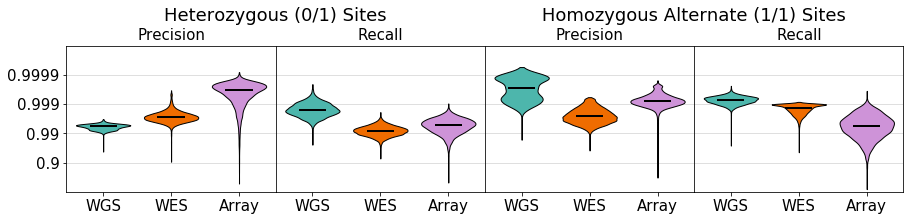

In [25]:
plot_precision_recall('../plots/sequencing_method.png',
                      [ihart_precision_recall, spark_exome_EX_precision_recall, spark_precision_recall],
                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), spark_exome_samples.is_child, spark_samples.is_child],
                      ['WGS', 'WES', 'Array'],
                      ['#4db6ac', '#ef6c00', '#ce93d8'])

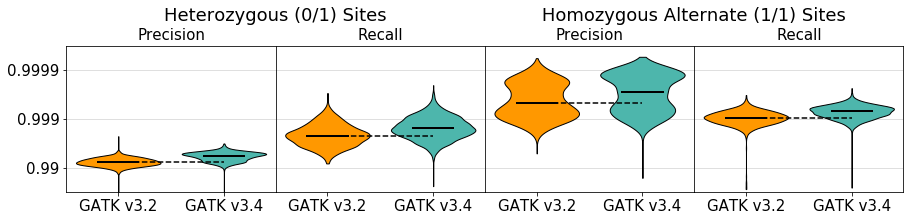

In [42]:
plot_precision_recall('../plots/gatk.png',
                      [ihart32_precision_recall, ihart_precision_recall],
                      [ihart32_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart32_samples.sample_ids]), 
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids])],
                      ['GATK v3.2', 'GATK v3.4'],
                      ['#ff9800', '#4db6ac'],
                     ylim=[1.5, 4.5],
                     dotted=True)



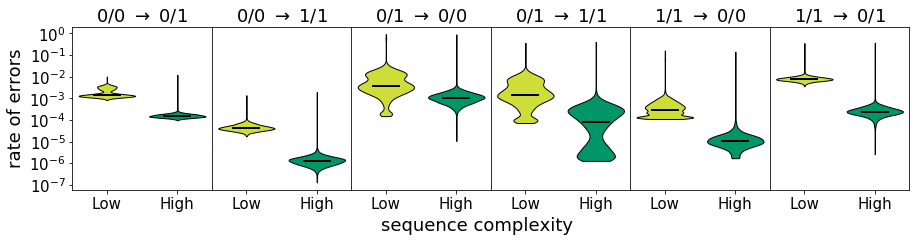

In [27]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#cedd38', '#009668']

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                      #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('sequence complexity', y=0, fontsize=18)

for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    error_rates1 = -ihart_LCR_error_rates[:, g_index, o_index]
    error_rates1 = error_rates1[ihart_samples.is_child & ~np.isnan(error_rates1)]
    
    error_rates4 = -ihart_HCR_error_rates[:, g_index, o_index]
    error_rates4 = error_rates4[ihart_samples.is_child & ~np.isnan(error_rates4)]
         
    parts = subs[i].violinplot([error_rates1, error_rates4],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticks(np.arange(-7, 1))
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 3))
    subs[i].set_xticklabels(['Low', 'High'], {'fontsize': 15})

fig.subplots_adjust(wspace=0.0)
#plt.savefig('../plots/lcr.png')
plt.show()

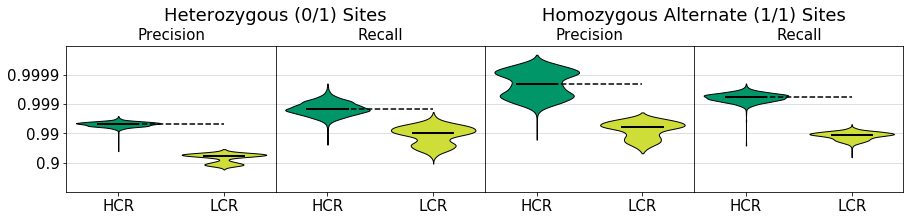

In [32]:
plot_precision_recall('../plots/lcr.png',
                      [ihart_HCR_precision_recall, ihart_LCR_precision_recall],
                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids])],
                      ['HCR', 'LCR'],
                      ['#009668', '#cedd38'],
                     dotted=True)




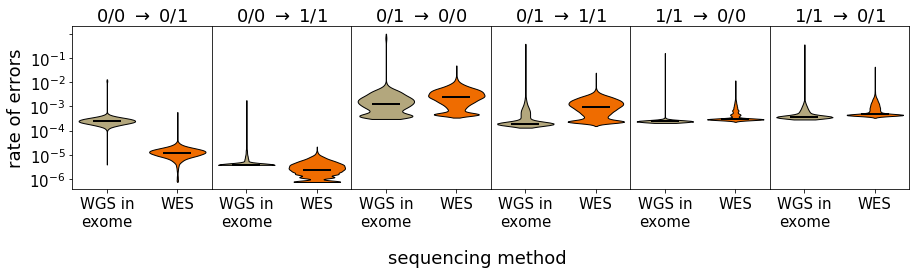

In [33]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#b3a77d', '#ef6c00']

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                      #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('sequencing method', y=-0.15, fontsize=18)

for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    error_rates1 = -ihart_EX_error_rates[:, g_index, o_index]
    indices1 = ihart_samples.is_child & ~np.isnan(error_rates1)
    error_rates1 = error_rates1
    
    error_rates2 = -spark_exome_EX_error_rates[:, g_index, o_index]
    indices2 = spark_exome_samples.is_child & ~np.isnan(error_rates2)
    error_rates2 = error_rates2
    
    #print(np.nanmedian(error_counts1[indices1])-np.nanmedian(error_counts2[indices2]))
    parts = subs[i].violinplot([error_rates1[indices1], error_rates2[indices2]],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        subs[i].set_ylabel('rate of errors', fontsize=18)
        #subs[i].set_yticks(np.arange(-7, 1))
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 3))
    subs[i].set_xticklabels(['WGS in\nexome', 'WES'], {'fontsize': 15})


fig.subplots_adjust(wspace=0.0)


#plt.tight_layout()
#plt.savefig('../plots/wgs_vs_wes.png')
plt.show()

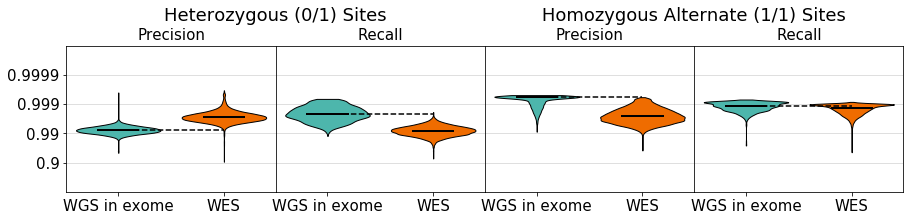

In [45]:
plot_precision_recall('../plots/wes.png',
                      [ihart_EX_precision_recall, spark_exome_EX_precision_recall],
                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), spark_exome_samples.is_child],
                      ['WGS in exome', 'WES', ],
                      ['#4db6ac', '#ef6c00'],
                     dotted=True)


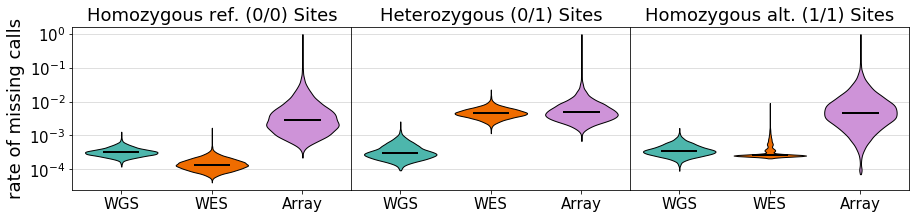

In [35]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#4db6ac', '#ef6c00', '#ce93d8', '#695d46', '#009668', '#b3a77d', '#cedd38']

errors_of_interest = [('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))

for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    error_rates1 = -ihart_error_rates[:, g_index, o_index]
    error_rates1 = error_rates1[ihart_samples.is_child & ~np.isnan(error_rates1)]
    
    error_rates2 = -spark_exome_EX_error_rates[:, g_index, o_index]
    error_rates2 = error_rates2[spark_exome_samples.is_child & ~np.isnan(error_rates2)]
    
    error_rates3 = -spark_error_rates[:, g_index, o_index]
    error_rates3 = error_rates3[spark_samples.is_child & ~np.isnan(error_rates3)]
     
    parts = subs[i].violinplot([error_rates1, error_rates2, error_rates3],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        subs[i].set_ylabel('rate of missing calls', fontsize=18)
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(['Homozygous ref. (0/0) Sites', 'Heterozygous (0/1) Sites', 'Homozygous alt. (1/1) Sites'][i], {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 4))
    subs[i].set_xticklabels(['WGS', 'WES', 'Array'], {'fontsize': 15})
    subs[i].grid(True, axis='y', alpha=0.5)
    subs[i].set_axisbelow(True)
    
fig.subplots_adjust(wspace=0.0)
plt.savefig('../plots/missing_calls.png')
#plt.show()

# Exome distance from target

In [38]:
all_samples = [spark_exome_samples]
all_error_rates = [spark_exome_EX_error_rates]
all_precision_recall = [spark_exome_EX_precision_recall]
for w in [25, 50, 75, 1000]:
    samples = compare_rates.pull_samples('../split_gen_spark_exome_EX%d' % w, chroms)
    all_samples.append(samples)

    error_rates = compare_rates.pull_error_rates(samples, 'params/spark_exome_EX%d_params.json' % w, gens, obss)
    all_error_rates.append(error_rates)
    
    precision_recall = compare_rates.pull_precision_recall(samples, 'params/spark_exome_EX%d_params.json' % w)
    all_precision_recall.append(precision_recall)
    
    
    


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


['1.00', '1.07', '1.33', '1.76', '1.95']
['1.00', '1.13', '1.11', '1.21', '1.07']
['1.00', '0.94', '1.76', '3.29', '3.88']
['1.00', '1.16', '2.59', '5.74', '7.33']
['1.00', '2.39', '2.19', '2.50', '3.05']
['1.00', '2.69', '6.11', '15.39', '17.21']


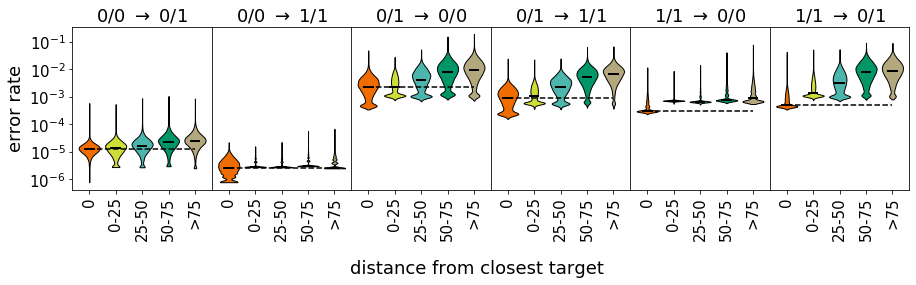

In [39]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#ef6c00', '#cedd38', '#4db6ac', '#009668', '#b3a77d', ]

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                    #('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('distance from closest target', y=-0.2, fontsize=18)



for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    
    to_plot = []
    for samples, error_rates in zip(all_samples, all_error_rates):
        add_plot = -error_rates[samples.is_child, g_index, o_index]
        add_plot = add_plot[~np.isnan(add_plot)]
        to_plot.append(add_plot)
             
    parts = subs[i].violinplot(to_plot,
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
        
    #subs[i].plot(range(1, 5), [np.median(x) for x in to_plot], color='black')
    subs[i].plot(range(1, 6), [np.median(to_plot[0])]*5, color='black', linestyle='--')
    print(['%0.2f' % 10.0**(np.median(x)-np.median(to_plot[0])) for x in to_plot])
    
    if i == 0:
        subs[i].set_ylabel('error rate', fontsize=18)
        #subs[i].set_ylim([-7, 1])
        subs[i].set_yticks(np.arange(-6, 1))
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 6))
    subs[i].set_xticklabels(['0', '0-25', '25-50', '50-75', '>75'], {'fontsize': 15})
    for tick in subs[i].get_xticklabels():
        tick.set_rotation(90)

fig.subplots_adjust(wspace=0.0)


#plt.tight_layout()
#plt.savefig(filename)
plt.show()

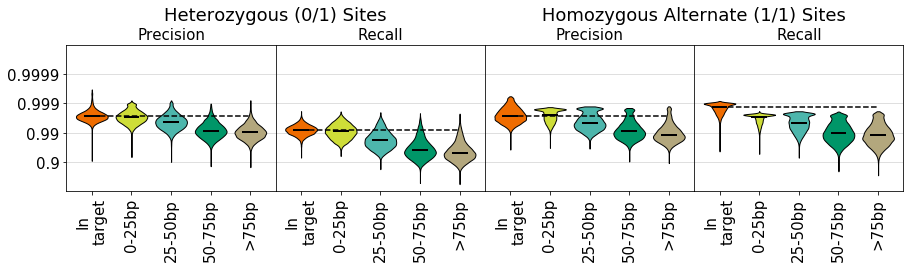

In [48]:
plot_precision_recall('../plots/wes_target.png',
                      all_precision_recall,
                      [samples.is_child for samples in all_samples],
                      ['In\ntarget', '0-25bp', '25-50bp', '50-75bp', '>75bp'],
                      ['#ef6c00', '#cedd38', '#4db6ac', '#009668', '#b3a77d', ],
                     dotted=True, rotate_xlabels=True)

